In [767]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sys
import string

from bs4 import BeautifulSoup
from collections import Counter
from datetime import datetime
from geotext import GeoText
from multiprocessing import Pool, cpu_count
from langdetect import detect
from loguru import logger
from lxml.html.clean import Cleaner
from lxml.html import fromstring, parse, HTMLParser
from pathlib import Path
from urllib.parse import urlparse
from time import time, strftime, gmtime
from warcio.archiveiterator import ArchiveIterator
from wget import download



In [4]:
#Configuring the logger
config = {"handlers": [{"sink": sys.stdout,"colorize": True,
          "format": "<green>{time:YYYY-MM-DD HH:mm:ss}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - <level>{message}</level>"}]}
logger.configure(**config)

[1]

In [5]:
# In case we need to persist some data, let's create a folder under Home directory -> Data and call it cc_news
data_folder = Path.home() / 'Data' / 'cc_news'
if not data_folder.is_dir():
    Path.mkdir(Path.home() / 'Data' / 'cc_news' , parents=True, exist_ok=True)

## Objective
Select a day’s worth of CC news articles and identify the top 10 discussed topics.

## Data
The list of Web Archive files on the Common Crawl News Channel can be obtained as such (Requires `aws cli` installed): 

In [6]:
list_of_files = !aws s3 ls --no-sign-request --human-readable --recursive s3://commoncrawl/crawl-data/CC-NEWS/2019/12

In [7]:
today = datetime.today().strftime('%Y/%m/%d')
print(f"There are {len(list_of_files)} files as of {today}") 

There are 391 files as of 2020/01/05


In [8]:
list_of_files[:10]

['2019-12-01 00:05:03 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201003247-02108.warc.gz',
 '2019-12-01 03:05:03 1023.1 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201043503-02109.warc.gz',
 '2019-12-01 06:05:03 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201075211-02110.warc.gz',
 '2019-12-01 09:05:02 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201104146-02111.warc.gz',
 '2019-12-01 11:05:03 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201132240-02112.warc.gz',
 '2019-12-01 14:05:03 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201154712-02113.warc.gz',
 '2019-12-01 16:05:02 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201180626-02114.warc.gz',
 '2019-12-01 19:05:03 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201202144-02115.warc.gz',
 '2019-12-01 22:05:02 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191201230603-02116.warc.gz',
 '2019-12-02 01:05:02 1023.0 MiB crawl-data/CC-NEWS/2019/12/CC-NEWS-20191202023532-02117.warc.gz']

### Basic stats about the files per day

Seems like the `warc.gz` files are named with CC-NEWS-{time_stamp} convention and the `s3` dates match the file names in terms dates. Mostly they are equal size 1GB files, so how many files per date? 

In [9]:
# Get the -nix -ls command's dates And count by date
dates = [url.split()[0] for url in list_of_files]
counts_by_date = Counter(dates) 

In [10]:
# Dates with fewest files
counts_by_date.most_common(len(counts_by_date))[:-4:-1]

[('2019-12-25', 8), ('2019-12-15', 8), ('2019-12-08', 8)]

In [11]:
# Dates with the most files
counts_by_date.most_common(len(counts_by_date))[:3]

[('2019-12-19', 24), ('2019-12-18', 23), ('2019-12-20', 19)]

In [12]:
# Average number of files per Day.
np.mean(list(counts_by_date.values()))

12.612903225806452

#### Basic Plotting
Let's just plot counts of files to see if there is a trend:

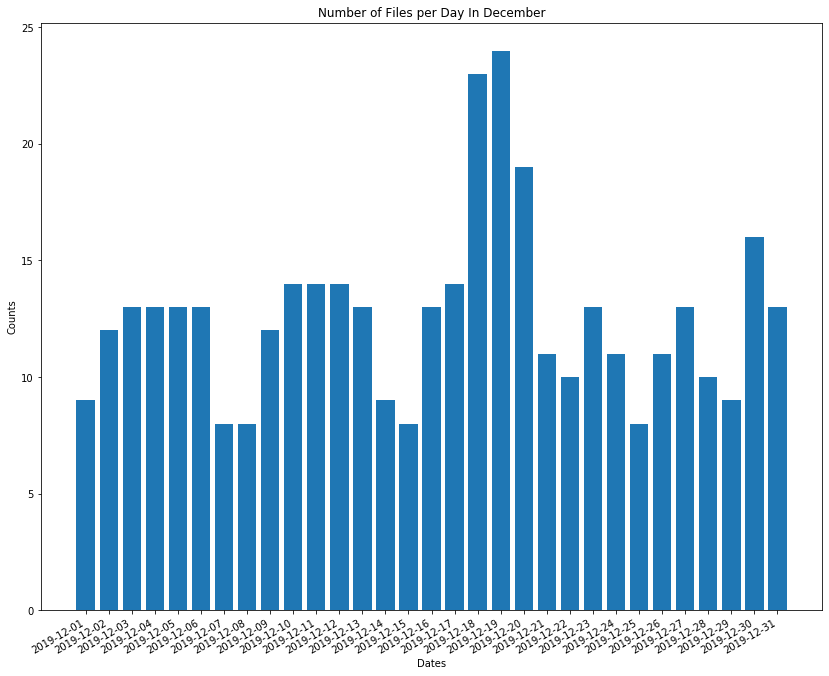

In [13]:
# Counter data, counter is your counter object
dates = [k for k in counts_by_date.keys()]
# get the counts for each date
count_per_date = [counts_by_date[k] for k in dates]

fig, ax = plt.subplots(figsize=(14, 12))
fig.autofmt_xdate()
plt.bar(dates, count_per_date)

plt.xlabel('Dates')
plt.ylabel('Counts')
plt.title('Number of Files per Day In December')

plt.show()

#### Observation
It is always good to plot your data.  Here, we can see there is weekly seasonality. During the weekends, there are less data and mid week there is steady stream of news. This might be because some of these news sites are actually Financial News Reporting sites and the markets are closed during the weekends or in general, not much is happening. 

There are 2 anamolies:
* December 18-19: Seems like Internet broke and some major stuff happened.
* December 25th: substantially lower volume since it was of course Christmas time. 


It might be interesting to find out what happened on December 18th and talked about for 2 days. So let's pick that date for our specific date to study. 

In [14]:
news_date = '2019-12-18'
needed_files = [file_name.split()[-1] for file_name in list_of_files if file_name.split()[0] == news_date]

In [15]:
# If we hit the https versions, we won't have to deal with s3 sign on issues. 
root_url = "https://commoncrawl.s3.amazonaws.com/"
file_urls  = [root_url + f for f in needed_files]

### Meta Data Extraction
Let's get some meta data from these files. Quick questions to answer:

* How many warc files are in each `.gz` file are there?
* How many of those warc files have actually a 200 response?
* How many of them are in English? (Previous scan has shown that this is a World Wide Web crawl in all languages which we have to discard as it is not of use to us for this project)
* How many of website domains are there?
* How many good (response=200) and English news pages are there per web domain? 

That's actually a lot.  

Here we will use `warcio` package's `ArchiveIterator` which does not download the files and can decompress the `.gz` and quickly iterate through the files. 
A Warc file has Response Headers (Warc headers), HTTP headers and response content in its simplest form. [More Information is here](https://commoncrawl.org/the-data/get-started/)

Let's check the first `warc` file with a 200 crawler response on the first `.gz` file:

In [16]:
# For The WARC Header
resp = requests.get(file_urls[0], stream=True)
for record in ArchiveIterator(resp.raw, arc2warc=True):
    if record.rec_type == 'response':
        print (record.rec_headers)
        break 

WARC/1.0
WARC-Record-ID: <urn:uuid:e9b214cd-aeb7-4f10-b49d-870a2d3f76ee>
Content-Length: 151065
WARC-Date: 2019-12-18T03:57:23Z
WARC-Type: response
WARC-IP-Address: 192.0.66.120
WARC-Target-URI: https://www.easttexasmatters.com/news/international/vote-to-remove-estonia-minister-over-jab-at-finnish-pm-fails/
Content-Type: application/http; msgtype=response
WARC-Payload-Digest: sha1:NDDJAGLNXU5IKEH3CWEIZU5LNRL4FKHM
WARC-Block-Digest: sha1:YQ754TWACN2G2F4LQS4FMN4R6KT2EEU3



Pretty basic meta data.  We can extract the domain name from `WARC-Target-URI` field. 

In [17]:
# For The HTTP Header
resp = requests.get(file_urls[0], stream=True)
for record in ArchiveIterator(resp.raw, arc2warc=True):
    if record.rec_type == 'response':
        print (record.http_headers)
        break 

HTTP/1.1 200 OK
Server: nginx
Date: Wed, 18 Dec 2019 03:57:24 GMT
Content-Type: text/html; charset=UTF-8
X-Crawler-Transfer-Encoding: chunked
Connection: keep-alive
X-hacker: If you're reading this, you should visit wpvip.com/careers and apply to join the fun, mention this header.
X-Powered-By: WordPress.com VIP <https://wpvip.com>
Link: <https://www.easttexasmatters.com/wp-json/>; rel="https://api.w.org/"
Link: <https://www.easttexasmatters.com/?p=241230>; rel=shortlink
X-Crawler-Content-Encoding: gzip
X-rq: dca3 112 86 3148
Cache-Control: max-age=300, must-revalidate
Age: 0
X-Cache: miss
Vary: Accept-Encoding
Accept-Ranges: bytes



Again pretty basic stuff that is not to our interest for our purposes. 

So far, we can answer almost all questions above except the language.  One way is to extract the body of the text and detect language on it using a library that has these models already trained (For reader's information, they are slightly more sophisticated than models trained classifiers on stop words). We can also try to extract the `lang` descriptor from the `html` tag on each page, if we can. Seems like parsing the text from the web content and then detecting the language is more time costly so let's try to get the language from the html tag first. If it is not English then we pass that file not detecting the language but if it says "English" then we make sure that it is. 

Let's start with the `BeautifulSoup` package to parse out the text from the web page because it is simpler to use.  However, my experience is that it does not scale well. 

In [18]:
# This utility function will clean the html body from <script> and <style> tags and then extract text
def get_text(content):
    souped= BeautifulSoup(content, "lxml")
    
    # Clean all script and style elements
    for script in souped(["script", "style"]):
        script.decompose()

    return souped.get_text(" ", strip=True)

In [20]:
# Language detection
resp = requests.get(file_urls[0], stream=True)
for record in ArchiveIterator(resp.raw, arc2warc=True):
    if record.rec_type == 'response':
        content = record.content_stream().read()
        tree = fromstring(content) 
        parsed_lang = tree.get("lang")
        text = get_text(content)
        detected_lang= detect(text)
        print(text)
        print("*"*80)
        print(parsed_lang)
        print(detected_lang)      
        break 

Vote to remove Estonia minister over jab at Finnish PM fails – KETK | FOX51 | EastTexasMatters.com Skip to content KETK | FOX51 | EastTexasMatters.com Tyler 36° Sponsored By Toggle Menu Open Navigation Close Navigation Search Primary Menu News Top Stories Local News Crime Texas News Veterans Voices East Texas Addicted Home for the Holidays Your Local Election HQ Special Reports BorderReport.com Texas Politics Washington D.C. National News Newsfeed Now Top Stories McDermott International relocates to Tyler in Plaza Tower Top Stories FBI involved in ‘continuous’ search for missing south Austin mom, infant; no person of interest Tool developed in Texas to predict power failures now being tested in California to prevent wildfires Four Dallas Cowboys headed to Pro Bowl Van Zandt County family loses everything in Monday house fire Weather Map Center Hurricane Tracker Interactive Radar Bus Stop Forecast Weather Talk Weather Headlines Weather Alerts Closings and Delays Sports Local Sports Frid

Nice! So this particular web page is tagged to be in "English - US". What we are interested in is all English derivates so we will parse out any that start out with "en"

Let's start putting together a function and print after processing 1000 records break at 3000. What we want is to count the English Pages.  Also, note that we are checking for domains to end with `.com` or `.uk`.  Other domains are more likely to be non-english speaking countries, such as, `www.t24.com.tr` is a Turkish news media outlet and we do not need to detect language for them. 

In [23]:
def get_meta_data_test(url):
    resp = requests.get(url, stream=True)
    
    domain_counter = Counter()
    
    for i, record in enumerate(ArchiveIterator(resp.raw, arc2warc=True)):
        if record.rec_type == 'response':
    
            uri = record.rec_headers.get_header('WARC-Target-URI')
            domain = urlparse(uri).netloc
            if domain.split('.')[-1] in ['com', 'uk']:
                try:
                    content = record.content_stream().read()
                    tree = fromstring(content) 
                    parsed_lang = tree.get("lang")
                except TypeError:
                    parsed_lang = None
                if parsed_lang is None or parsed_lang[:2].lower() ==  'en':
                    try:
                        detected_lang = detect(get_text(content))
                    except:
                        detected_lang = "can't detect"
                    if detected_lang == 'en':
                        domain_counter.update({domain: 1})

            if i % 1000 == 0 :
                logger.info(f"I have processed {i} warc files so far")
                logger.info(f"\tI found {sum(domain_counter.values())} English pages")
                logger.info(f"\tI found {len(domain_counter.keys())} domains")

            
        if i ==3001:
            print(domain_counter)
            break
            

In [24]:
start_time = time()
get_meta_data_test(file_urls[0])
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-05 11:12:54 | INFO     | __main__:get_meta_data_test:27 - I have processed 1000 warc files so far
2020-01-05 11:12:54 | INFO     | __main__:get_meta_data_test:28 - 	I found 291 English pages
2020-01-05 11:12:54 | INFO     | __main__:get_meta_data_test:29 - 	I found 37 domains
2020-01-05 11:13:46 | INFO     | __main__:get_meta_data_test:27 - I have processed 2000 warc files so far
2020-01-05 11:13:46 | INFO     | __main__:get_meta_data_test:28 - 	I found 520 English pages
2020-01-05 11:13:46 | INFO     | __main__:get_meta_data_test:29 - 	I found 64 domains
2020-01-05 11:14:52 | INFO     | __main__:get_meta_data_test:27 - I have processed 3000 warc files so far
2020-01-05 11:14:52 | INFO     | __main__:get_meta_data_test:28 - 	I found 770 English pages
2020-01-05 11:14:52 | INFO     | __main__:get_meta_data_test:29 - 	I found 99 domains
Counter({'www.pcgamer.com': 83, 'www.easttexasmatters.com': 75, 'www.saucey.com': 60, 'www.michigansthumb.com': 53, 'www.seattlepi.com': 51, 'www

Looking at the domain names, it looks like we got what we wanted, however, it took a whopping a minute for 1000 warc files. We would be looking at roughly an hour to process all of our data, which seems not good. I suspect this is due to `BeatifulSoup`, need to run the profiler on this function to make sure, but for practical purposes, let's go ahead and refactor the code with `lxml` 

In [26]:
# Specificy parser to remove blanks
parser = HTMLParser(remove_blank_text=True)
# Instantiate Cleaner to strip scripts, styles and links for our purposes
cleaner = Cleaner(scripts=True, javascript=True, style=True, links=True)

Let's make sure we will get the same results that we got with Beautiful Soup

In [33]:
resp = requests.get(file_urls[0], stream=True)
for record in ArchiveIterator(resp.raw, arc2warc=True):
    if record.rec_type == 'response':
        content = record.content_stream().read()
        tree = fromstring(content, parser=parser)
        parsed_lang = tree.get("lang")
        tree = cleaner.clean_html(tree)
    
        text = tree.text_content().strip()
        text = " ".join(text.split())
        detected_lang= detect(text)
        
        print(text)
        print("*"*80)
        print(parsed_lang)
        print(detected_lang) 
     
        break 

Vote to remove Estonia minister over jab at Finnish PM fails – KETK | FOX51 | EastTexasMatters.com Skip to content KETK | FOX51 | EastTexasMatters.com Tyler 36° Sponsored By Search Primary Menu News Top Stories Local News Crime Texas News Veterans Voices East Texas Addicted Home for the Holidays Your Local Election HQ Special Reports BorderReport.com Texas Politics Washington D.C. National News Newsfeed Now Top Stories McDermott International relocates to Tyler in Plaza Tower Top Stories FBI involved in ‘continuous’ search for missing south Austin mom, infant; no person of interest Tool developed in Texas to predict power failures now being tested in California to prevent wildfires Four Dallas Cowboys headed to Pro Bowl Van Zandt County family loses everything in Monday house fire Weather Map Center Hurricane Tracker Interactive Radar Bus Stop Forecast Weather Talk Weather Headlines Weather Alerts Closings and Delays Sports Local Sports Friday Football Fever presented by SUBWAY® Athlet

Yes! A little bit more cumborsome but it is the same thing. Let's refactor the function. 

In [31]:
def get_meta_data_test_lxml(url):
    resp = requests.get(url, stream=True)
    
    domain_counter = Counter()
    
    for i, record in enumerate(ArchiveIterator(resp.raw, arc2warc=True)):
        if record.rec_type == 'response':
    
            uri = record.rec_headers.get_header('WARC-Target-URI')
            domain = urlparse(uri).netloc
            if domain.split('.')[-1] in ['com', 'uk']:
                content = record.content_stream().read()
                tree = fromstring(content, parser=parser)

                try:
                    tree = fromstring(content) 
                    parsed_lang = tree.get("lang")
                except TypeError:
                    parsed_lang = None
                if parsed_lang is None or parsed_lang[:2].lower() ==  'en':
                    try:
                        tree = cleaner.clean_html(tree)
                        text = tree.text_content().strip()
                        text = " ".join(text.split())
                        detected_lang= detect(text)
                    except:
                        detected_lang = "can't detect"
                    if detected_lang == 'en':
                        domain_counter.update({domain: 1})

            if i % 1000 == 0 :
                logger.info(f"I have processed {i} warc files so far")
                logger.info(f"\tI found {sum(domain_counter.values())} English pages")
                logger.info(f"\tI found {len(domain_counter.keys())} domains")

        if i ==3000:
            print(domain_counter)
            break
            

In [32]:
start_time = time()
get_meta_data_test_lxml(file_urls[0])
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-05 11:28:37 | INFO     | __main__:get_meta_data_test_lxml:32 - I have processed 1000 warc files so far
2020-01-05 11:28:37 | INFO     | __main__:get_meta_data_test_lxml:33 - 	I found 294 English pages
2020-01-05 11:28:37 | INFO     | __main__:get_meta_data_test_lxml:34 - 	I found 38 domains
2020-01-05 11:28:47 | INFO     | __main__:get_meta_data_test_lxml:32 - I have processed 2000 warc files so far
2020-01-05 11:28:47 | INFO     | __main__:get_meta_data_test_lxml:33 - 	I found 523 English pages
2020-01-05 11:28:47 | INFO     | __main__:get_meta_data_test_lxml:34 - 	I found 65 domains
2020-01-05 11:28:57 | INFO     | __main__:get_meta_data_test_lxml:32 - I have processed 3000 warc files so far
2020-01-05 11:28:57 | INFO     | __main__:get_meta_data_test_lxml:33 - 	I found 773 English pages
2020-01-05 11:28:57 | INFO     | __main__:get_meta_data_test_lxml:34 - 	I found 100 domains
Counter({'www.pcgamer.com': 83, 'www.easttexasmatters.com': 75, 'www.saucey.com': 60, 'www.michigan

A `6x` speed performance improvement.  Love `lxml`. From now on, we shall go with `lxml`. Let's process one file. 

First modify the function: 

In [34]:
def get_meta_data(url):
    resp = requests.get(url, stream=True)
    
    domain_counter = Counter()
    for i, record in enumerate(ArchiveIterator(resp.raw, arc2warc=True)):
        if record.rec_type == 'response':
    
            uri = record.rec_headers.get_header('WARC-Target-URI')
            domain = urlparse(uri).netloc
            if domain.split('.')[-1] in ['com', 'uk']:
                content = record.content_stream().read()
                tree = fromstring(content, parser=parser)

                try:
                    tree = fromstring(content) 
                    parsed_lang = tree.get("lang")
                except TypeError:
                    parsed_lang = None
                if parsed_lang is None or parsed_lang[:2].lower() ==  'en':
                    try:
                        tree = cleaner.clean_html(tree)
                        text = tree.text_content().strip()
                        text = " ".join(text.split())
                        detected_lang= detect(text)
                    except:
                        detected_lang = "can't detect"
                    if detected_lang == 'en':
                        domain_counter.update({domain: 1})

    logger.info(f"I have processed {i} warc files in Total!")
    logger.info(f"I found {sum(domain_counter.values())} English pages")
    logger.info(f"I found {len(domain_counter.keys())} domains")
            
    return domain_counter

In [35]:
start_time = time()
domains = get_meta_data(file_urls[0])
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-05 12:09:42 | INFO     | __main__:get_meta_data:30 - I have processed 71548 warc files in Total!
2020-01-05 12:09:42 | INFO     | __main__:get_meta_data:31 - I found 14348 English pages
2020-01-05 12:09:42 | INFO     | __main__:get_meta_data:32 - I found 1292 domains
2020-01-05 12:09:42 | INFO     | __main__:<module>:4 - It took 00:10:15 to run this script!


In [36]:
# Get the most common domains
domains.most_common(20)

[('www.pcgamer.com', 1637),
 ('irvineobserver.com', 281),
 ('www.easttexasmatters.com', 232),
 ('www.dailymail.co.uk', 221),
 ('www.legacy.com', 206),
 ('www.informnny.com', 152),
 ('www.nwahomepage.com', 135),
 ('www.wivb.com', 129),
 ('www.sheltonherald.com', 117),
 ('www.bigcountryhomepage.com', 116),
 ('www.nhregister.com', 116),
 ('www.fairfieldcitizenonline.com', 114),
 ('www.chron.com', 113),
 ('www.seattlepi.com', 109),
 ('www.theridgefieldpress.com', 108),
 ('www.wiltonbulletin.com', 108),
 ('www.mrt.com', 106),
 ('www.michigansthumb.com', 105),
 ('www.sfgate.com', 104),
 ('www.ctpost.com', 103)]

This is from just the first file.  One file took 10+ minutes so if we run a loop processing through all files will take about 4 hours even for this simple function. That's a way too long. Can we parellize the process?  But before we do that, let's just simplify the function just to see it works. We will take out the language detection from text part out. 

In [38]:
def get_meta_data_p(url):
    resp = requests.get(url, stream=True)
    
    domain_counter = Counter()
    if record.rec_type == 'response':
        uri = record.rec_headers.get_header('WARC-Target-URI')
        domain = urlparse(uri).netloc
        if domain.split('.')[-1] in ['com', 'uk']:
            content = record.content_stream().read()
            tree = fromstring(content, parser=parser)
            try:
                tree = fromstring(content) 
                parsed_lang = tree.get("lang")
            except TypeError:
                parsed_lang = None
            if detected_lang == 'en':
                domain_counter.update({domain: 1})        
    return domain_counter

In [39]:
cpu_count() -1

23

In [43]:
# For testing purposes, do not run:
if 1 == 0:
    start_time = time()
    with Pool(processes=(cpu_count() -1)) as proc:
        results = list(proc.imap(get_meta_data_p, file_urls))
    elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
    logger.info(f'It took {elapsed} to run this script!')

It took a whopping 36 mins to run through 23 files. One file takes a little over 2 mins, so if we serialized it, we would expect it to take about 50 mins. So there is about 40% improvement but this code is run on a 12 core 24 thread machine so there is a bottleneck here. It is likely that there are some S3 Bucket "same machine/simultaneous streaming" constraints that is throttling the streaming. I see all cores fired up but only 6 of them is maximized at any given time.  And if we added the language detection part, then we would be looking at 4 hours. Way way too long. 

This have to take the hit and download these files onto the machine.  This way we can take a one-time hit but eliminate network streaming issues.  After all, we were trying to stream through 23, GB files at the same time. 

Belove code leverages `wget` package which is a wrapper around 'nix `wget` and will download the files into our data folder. It takes about 90 seconds per file. 

In [ ]:
# Do not run unless you want to download these files onto your machine. 
#for url in file_urls:
#    wget.download(url, str(data_folder / url.split('/')[-1]))

In [46]:
# Get File URIs
files = [str(x) for x in data_folder.glob('*') if x.is_file()]

Now, we have to refactor the function to read warc.gz files on the machine instead of streaming them from the s3 bucket. 

In [56]:
def get_meta_data_f(uri):
    domain_counter = Counter()
    with open(uri, 'rb') as stream:
        for i, record in enumerate(ArchiveIterator(stream, arc2warc=True)):
            if record.rec_type == 'response':
                warc_uri = record.rec_headers.get_header('WARC-Target-URI')
                domain = urlparse(warc_uri).netloc
                if domain.split('.')[-1] in ['com', 'uk']:
                    content = record.content_stream().read()
                    tree = fromstring(content, parser=parser)
                    try:
                        tree = fromstring(content) 
                        parsed_lang = tree.get("lang")
                    except TypeError:
                        parsed_lang = None
                        detected_lang = None
                        pass
                    if parsed_lang[:2].lower() ==  'en':
                        try:
                            tree = cleaner.clean_html(tree)
                            text = tree.text_content().strip()
                            text = " ".join(text.split())
                            detected_lang= detect(text)
                        except:
                            detected_lang = "can't detect"
                        if detected_lang == 'en':
                            domain_counter.update({domain: 1})

    logger.info(f"I have processed {i} warc files in Total!")
    logger.info(f"I found {sum(domain_counter.values())} English pages")
    logger.info(f"I found {len(domain_counter.keys())} domains")
            
    return domain_counter

Let's try it on one file:

In [51]:
start_time = time()
domains = get_meta_data_f(files[0])
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-05 13:09:29 | INFO     | __main__:get_meta_data_f:28 - I have processed 66830 warc files in Total!
2020-01-05 13:09:29 | INFO     | __main__:get_meta_data_f:29 - I found 13817 English pages
2020-01-05 13:09:29 | INFO     | __main__:get_meta_data_f:30 - I found 713 domains
2020-01-05 13:09:29 | INFO     | __main__:<module>:4 - It took 00:08:42 to run this script!


Let's Parallelize the function and leverage all cores available... 

In [63]:
def get_meta_data_f_p(uri):
    domain_counter = Counter()
    with open(uri, 'rb') as stream:
        for i, record in enumerate(ArchiveIterator(stream, arc2warc=True)):
            if record.rec_type == 'response':
                warc_uri = record.rec_headers.get_header('WARC-Target-URI')
                domain = urlparse(warc_uri).netloc
                if domain.split('.')[-1] in ['com', 'uk']:
                    content = record.content_stream().read()
                    try:
                        tree = fromstring(content, parser=parser)
                        parsed_lang = tree.get("lang")
                        if parsed_lang[:2].lower() ==  'en':
                            try:
                                tree = cleaner.clean_html(tree)
                                text = tree.text_content().strip()
                                text = " ".join(text.split())
                                detected_lang= detect(text)
                            except:
                                detected_lang = None
                            if detected_lang == 'en':
                                domain_counter.update({domain: 1})
                    except:
                        parsed_lang = None
                        detected_lang = None
                        pass
                            
    return domain_counter, i

In [125]:
start_time = time()
with Pool(processes=(cpu_count() -1)) as proc:
    results = list(proc.imap(get_meta_data_f_p, files))
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-05 17:26:22 | INFO     | __main__:<module>:5 - It took 00:12:44 to run this script!


Combine results from all files: 

In [73]:
all_domains = Counter()
num_files = []
for dom in results:
    all_domains = all_domains + dom[0]
    num_files.append(dom[1])

In [90]:
print(f"We have processed total of {sum(num_files):,} files.")
print(f"We have got a hit for {sum(all_domains.values()):,} web pages in English!")
print(f"In this set, there are {len(all_domains.keys()):,} unique domains!")

We have processed total of 1,669,087 files.
We have got a hit for 233,913 web pages in English!
In this set, there are 5,063 unique domains!


All this in 12 mins on this machine is not bad and can be optimized even further but this will do for the time being. Let's take a look at the top domains:

In [126]:
print(f"And here are the domains with the most hits:")
print(*all_domains.most_common(30), sep = "\n")

And here are the domains with the most hits:
('www.pcgamer.com', 14079)
('www.sbwire.com', 6919)
('www.releasewire.com', 6875)
('www.gamesradar.com', 6775)
('www.musicradar.com', 6654)
('www.itproportal.com', 6619)
('www.tesco.com', 6498)
('www.autotrader.co.uk', 4472)
('www.whatsonstage.com', 4340)
('www.theatermania.com', 3134)
('irvineobserver.com', 2623)
('www.ii.co.uk', 2531)
('www.mysmartrend.com', 1921)
('www.devdiscourse.com', 1756)
('www.goal.com', 1697)
('www.onenewspage.com', 1601)
('www.bhg.com', 1388)
('www.bbc.co.uk', 1278)
('www.reuters.com', 1265)
('shopping.yahoo.com', 1105)
('www.refinery29.com', 1104)
('www.ultimate-guitar.com', 1014)
('www.pagalguy.com', 1000)
('www.eglobalist.com', 1000)
('www.eastlaketimes.com', 969)
('www.thehindu.com', 928)
('www.sfchronicle.com', 840)
('www.houstonchronicle.com', 837)
('www.westernjournal.com', 826)
('www.prnewswire.com', 818)


#### Observations

A few quick ones:
* There are non news sites, mostly ecommerce, i.e. pcgamer, musicradar, autotrader, whatsonstage, shopping.yahoo.com, etc. I am not sure why they are being scraped but is a problem.
* There are some legit news sites like, reuters.com, bbc.co.uk
* There are some sports sites for sports related news, like goal.com
* There are some IT related sites
* There are some financial business news sites
* And there is a bunch of local sites like thehindu.com. 

So how do we go about all this?  We have to create a filter for what we want and categorize these sites.

One way to train a model on some corpus like newsgroups and classify the domains via their title or description.
That seems a good idea but in the interest of time might be too much. 

We could also get their descriptions and titles and try to classify them on a rule based method. 

In [249]:
min_thresh = 10
sorted_doms = dict(all_domains.most_common())
all_domains_thresh = {x : most_common[x] for x in most_common if most_common[x] >= min_thresh}

In [333]:
def get_titles (doms):
    results = []
    for dom in doms:
        result = {}
        try:
            web_response = requests.get("http://" + dom, timeout=(10,20)) 
            tree = fromstring(web_response.text)
            title = tree.xpath("//title/text()")
            title = str(title[0]) if title else None
            description = tree.xpath("//meta[@name='description']/@content")
            description = str(description[0]) if description else None
            
            result = {'domain':dom, 'title':title, 'description': description}
        except:
            result = {'domain':dom, 'title':None, 'description': None }
        results.append(result)
    print(results)

In [334]:
start_time = time()
subset_titles = get_titles(list(most_common_doms.keys())[:5])
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

[{'domain': 'www.pcgamer.com', 'title': None, 'description': None}, {'domain': 'www.sbwire.com', 'title': None, 'description': None}, {'domain': 'www.releasewire.com', 'title': None, 'description': None}, {'domain': 'www.gamesradar.com', 'title': None, 'description': None}, {'domain': 'www.musicradar.com', 'title': None, 'description': None}]
2020-01-05 23:17:50 | INFO     | __main__:<module>:4 - It took 00:00:02 to run this script!


In [206]:
list(most_common_doms.keys())[:10]

['www.pcgamer.com',
 'www.sbwire.com',
 'www.releasewire.com',
 'www.gamesradar.com',
 'www.musicradar.com',
 'www.itproportal.com',
 'www.tesco.com',
 'www.autotrader.co.uk',
 'www.whatsonstage.com',
 'www.theatermania.com']

In [351]:
def get_titles_p (dom):
    try:
        web_response = requests.get("http://" + dom, timeout=(10,20)) 
        tree = fromstring(web_response.text)
        title = tree.xpath("//title/text()")
        title = title[0] if title else None
        description = tree.xpath("//meta[@name='description']/@content")
        description = description[0] if description else None
            
        result = {'domain':dom, 'title':title, 'description': description}   
    except:
        result = {'domain':dom, 'title': None, 'description': None}
    return result

In [352]:
start_time = time()
with Pool(processes=(cpu_count() -1)) as proc:
    titles = list(proc.imap(get_titles_p, list(sorted_doms.keys())))
elapsed = strftime("%H:%M:%S", gmtime(time() - start_time))
logger.info(f'It took {elapsed} to run this script!')

2020-01-06 13:53:41 | INFO     | __main__:<module>:5 - It took 00:03:28 to run this script!


In [639]:
df = pd.DataFrame(titles, columns=['domain', 'title', 'description'])
print(df.shape)
print(df.head())
print("*"*80)
print(f"Number of domains with no title or description {df[df.title.isna() & df.description.isna()].shape[0]}")

(5063, 3)
                domain                                              title  \
0      www.pcgamer.com                                           PC Gamer   
1       www.sbwire.com               SBWire - The Small Business Newswire   
2  www.releasewire.com                                               None   
3   www.gamesradar.com                                        GamesRadar+   
4   www.musicradar.com  Music Gear, Equipment, News, Tutorials & Revie...   

                                         description  
0  PC Gamer is your source for exclusive reviews,...  
1                                               None  
2                                               None  
3  GamesRadar+ takes you closer to the games, mov...  
4  Get up to the minute news and reviews for all ...  
********************************************************************************
Number of domains with no title or description 63


### Observation
Pretty good... We have gotten the titles and descriptions of 5000+ domains and only small portion (~1%) of them has neither. 

### Get locality
Can we extract Geo Locations from the title's and descriptions?  A quick way is to leverage `geotext` package.  A more eloborate Entity Recognition could be to use `spacy` package, even more advanced state of the art methods would be to use BERT like transformer models.  Let's do a quick and dirty version. First a function as always:

In [640]:
def get_locality (desc, title):
    if desc:
        places = GeoText(desc)
        city = places.cities[0] if places.cities else None
        country = places.countries[0] if places.countries else None
        return [city, country]
    elif title:
        places = GeoText(title)
        city = places.cities[0] if places.cities else None
        country = places.countries[0] if places.countries else None
        return [city, country]
    else:
        return [None, None]

In [641]:
# Apply and create new fields
df['city'], df['country'] = zip(*df.apply(lambda row: get_locality(row['description'], row['title']), axis=1))

In [642]:
df[~df.city.isna()]

,domain,title,description,city,country
8,www.whatsonstage.com,"Theatre shows, special offers, news, reviews a...",Find London theatre tickets for current shows ...,West End,None
26,www.sfchronicle.com,"San Francisco Chronicle - Bay Area news, sport...",Exclusive Bay Area and San Francisco breaking ...,San Francisco,None
27,www.houstonchronicle.com,Houston Chronicle | HoustonChronicle.com - Hou...,"Get the latest news on Houston, Texas, the Uni...",Houston,United States
36,www.washingtonpost.com,"Washington Post: Breaking News, World, US, DC ...","Breaking news and analysis on politics, busine...",Virginia,None
46,www.seattletimes.com,"The Seattle Times | Local news, sports, busine...","Local news, sports, business, politics, entert...",Seattle,None
...,...,...,...,...,...
5023,www.stratfordbeaconherald.com,"\n\t\tStratford News, Sports, Entertainment, B...","Find Stratford breaking news, latest stories, ...",Stratford,Canada
5028,riverjournalonline.com,"River Journal Online – News for Tarrytown, Sle...",The River Journal is the local paper for Irvin...,Irvington,None
5032,www.goderichsignalstar.com,"\n\t\tGoderich News, Sports, Entertainment, Bu...","Find Goderich breaking news, latest stories, r...",Ontario,Canada
5035,www.wktv.com,"WKTV - Utica News, Weather, Sports & Breaking ...",WKTV NewsChannel 2 is your leading provider of...,York,None


Pretty good results. Although we do not have an immediate use for it, it is good information, we may use it to detect local news for specific locations. 

### Manual abeling
How do we classify whether the domain is really news, not news (like tesco.com), sports or financial specific. We will manually hand label some of these domains.
1. Save the data on to disk
2. Open the file on a spreadsheet app
3. Hand label some records and save

In [769]:
# Save to disk
df.to_csv(data_folder / 'domains.csv', index=False, header=True)

In [830]:
df_labeled = pd.read_csv(data_folder / 'domains_labeled.csv')

In [831]:
df_labeled.label.value_counts()

news              29
other             27
financial_news    18
tech_news         11
sports            11
entertainment     10
Name: label, dtype: int64

Here, we labeled about 100 domains in a few minutes into 6 classes. `Active learning` could be applied to increase the human labeled records. Or crowd source and label all 5,000+ domains. 

We got our labels, How about our Input text? We will concatenate our title and description fields.

In [832]:
df_labeled['title_desc'] = df_labeled['title'].fillna('') + '. ' + df_labeled['description'].fillna('')
df_labeled

,label,domain,title,description,city,country,title_desc
0,entertainment,www.thesun.co.uk,"News, sport, celebrities and gossip | The Sun","Get the latest news, exclusives, sport, celebr...",NaN,NaN,"News, sport, celebrities and gossip | The Sun...."
1,entertainment,parade.com,Parade,"Your daily destination for celebrity news, vid...",NaN,NaN,Parade. Your daily destination for celebrity n...
2,entertainment,usweekly.com,USweekly,NaN,NaN,NaN,USweekly.
3,entertainment,www.whatsontv.co.uk,TV guide to top UK TV and soap spoilers | What...,"What’s on TV is the best guide to UK TV, news,...",NaN,NaN,TV guide to top UK TV and soap spoilers | What...
4,entertainment,www.eonline.com,"Entertainment News, Celebrity Gossip, Celebrit...","Your source for entertainment news, celebritie...",NaN,NaN,"Entertainment News, Celebrity Gossip, Celebrit..."
...,...,...,...,...,...,...,...
5058,NaN,www.daviddavismp.com,Rt Hon David Davis MP,NaN,NaN,NaN,Rt Hon David Davis MP .
5059,NaN,www.ptleader.com,Port Townsend Leader,NaN,NaN,NaN,Port Townsend Leader.
5060,NaN,www.hotelbusiness.com,Home | Hotel Business,Hotel Business - A leader in hospitality news ...,NaN,NaN,Home | Hotel Business. Hotel Business - A lead...
5061,NaN,pets.webmd.com,Pet Health Center | Veterinary Care and Inform...,Welcome to the new WebMD Pet Health Center. We...,NaN,NaN,Pet Health Center | Veterinary Care and Inform...


### Train and validation split 

In [833]:
from sklearn.model_selection import train_test_split

In [834]:
df_abt = df_labeled.loc[~df_labeled.label.isna()].copy()

In [835]:
X_train, X_val, y_train, y_val = train_test_split(df_abt['title_desc'], df_abt['label'], random_state=210, test_size=0.1, stratify=df_abt['label'])

In [836]:
y_val.value_counts()

news              3
other             3
financial_news    2
tech_news         1
entertainment     1
sports            1
Name: label, dtype: int64

Now we need to train a basic classifier for our purpose. We will leverage Naive Bayes which is my go-to classifier for any Text Classification problem to get a base.  It is quick and most cases gives a reasonable enough result. 

In [837]:
# Vectorize ->  Term Frequency Matrix creation
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(strip_accents='unicode', stop_words='english') # Remove Stop Words 

In [838]:
X_train_vec = vectorize.fit_transform(X_train)
X_val_vec = vectorize.transform(X_val)

In [839]:
# Spot checking 
word_freq = pd.DataFrame(X_train_vec.toarray(), columns=vectorize.get_feature_names())
word_freq.head()

,000,10,100,14,19,2004,2018,2019,360,400,...,windows,winning,woman,women,world,written,yahoo,york,zdnet,zealand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [840]:
top_words = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words.head()

,0
news,326
sports,72
weather,67
breaking,61
latest,59


Makes sense. We can now fit our model

In [841]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [842]:
# Get our predictions on the validation set
preds = naive_bayes.predict(X_val_vec)

In [843]:
# Calculate accuracy metrics
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
print(f'Accuracy: {round(accuracy_score(y_val, preds), 2)}')
print(f'Matthews Correlation Coefficient: {round(matthews_corrcoef(y_val, preds),2)}')

Accuracy: 0.91
Matthews Correlation Coefficient: 0.89


### Observation
That's pretty good based on a few records. Obviously, we cheated a little. If we do Cross validation, or resample our train/test splits, the average accuracy metrics may not be as good. However, for demonstration purposes, this is good enough.  Let's plot the confusion matrix

In [844]:
# Get labels 
labels = df_abt.label.value_counts().index.tolist()
labels = df_abt.label.unique().tolist()
labels

['entertainment', 'financial_news', 'news', 'other', 'sports', 'tech_news']

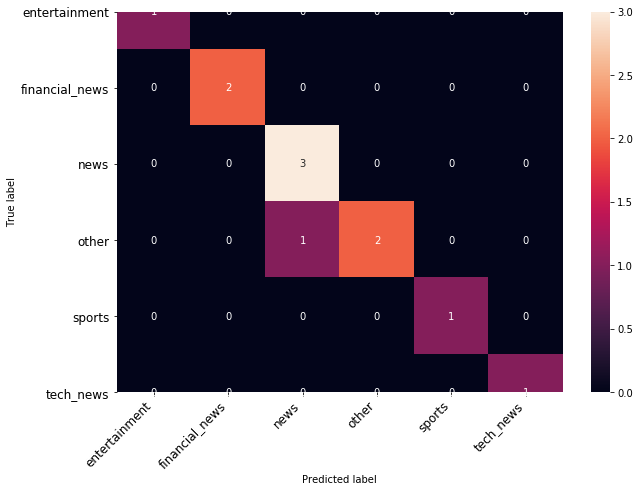

In [845]:
# Plotting the Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_val, preds), index=labels, columns=labels)
plt.figure(figsize = (10,7))
heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


We are missing one. Let's check it out

In [846]:
validation = df_abt.iloc[y_val.index].copy()
validation['preds'] = preds
list(validation[validation.label != validation.preds].title_desc)

['Automated Test and Automated Measurement Systems - National Instruments. NI equips engineers and scientists with systems that accelerate productivity, innovation, and discovery.']

### Observation
This should have been Other but was classified as "News". Obviously, more training data will help. We just head 100+ records. 

Let's get all of the other records classed. 

In [847]:
X_test_vec= vectorize.transform(df_labeled.loc[df_labeled.label.isna(), 'title_desc'])
test_preds = naive_bayes.predict(X_test_vec)
df_labeled.loc[df_labeled.label.isna(), 'label'] = test_preds

In [851]:
# Sample some
df_labeled.sample(frac=1, random_state=99).groupby('label').head(2)

,label,domain,title,description,city,country,title_desc
1977,financial_news,blueandgreentomorrow.com,Blue and Green Tomorrow: Ethical Investments &...,"Find news, advice and information about Sustai...",NaN,NaN,Blue and Green Tomorrow: Ethical Investments &...
1881,news,www.tdtnews.com,tdtnews.com,NaN,NaN,NaN,tdtnews.com.
2889,news,blueridgemuse.com,"Blue Ridge Muse – News, views and musings from...",NaN,NaN,NaN,"Blue Ridge Muse – News, views and musings from..."
2571,sports,nhl.nbcsports.com,"NHL News, Video, Scores | NBC Sports' ProHocke...","Find the latest NHL hockey live scores, standi...",NaN,NaN,"NHL News, Video, Scores | NBC Sports' ProHocke..."
3005,tech_news,upstatehouse.com,Upstate House - At home in the Hudson Valley U...,At home in the Hudson Valley,NaN,NaN,Upstate House - At home in the Hudson Valley U...
732,financial_news,www.canindia.com,Canindia News – Canada's favorite south asian ...,NaN,NaN,Canada,Canindia News – Canada's favorite south asian ...
104,tech_news,www.geeky-gadgets.com,Geeky Gadgets - Gadgets and Technology News,Geeky Gadgets brings you the latest gadgets an...,NaN,NaN,Geeky Gadgets - Gadgets and Technology News. G...
3665,sports,www.packersnews.com,PackersNews.com -- Green Bay Packers news fro...,Green Bay Packers fans can catch the latest te...,Green Bay,NaN,PackersNews.com -- Green Bay Packers news fro...
1362,other,www.metalunderground.com,Metal Underground.com - some music was meant t...,NaN,NaN,NaN,Metal Underground.com - some music was meant t...
2833,entertainment,303magazine.com,303 MAGAZINE | FASHION • CULTURE • STYLE,"For the past 13 years, known as Denver's best ...",Denver,NaN,303 MAGAZINE | FASHION • CULTURE • STYLE. For ...


### Commentary
They look reasonable enough.  We got several of them right. The final distribution of the 5K domains are as such: 

In [852]:
df_labeled.label.value_counts()

news              3685
other              462
financial_news     344
tech_news          200
sports             191
entertainment      181
Name: label, dtype: int64

In [853]:
# Saving the record set
df_labeled.to_csv(data_folder / 'domains_labeled_complete.csv', header=True, index=False)

## End of Notebook

We 
1. extracted some high level meta data from the corpus
2. Performed some basic EDA done
3. Were able to pull the text data and detect the language on it. 
4. Extracted the English Domains
5. On a gross level classified these English domains included in the set into 6 main categories. 
6. And did some parallelization to speed up the process

All this is not trivial work, but more to come.  For the next steps, we will

1. Run through the corpus with our classified English domain list
2. Filter out `other` domains that are most likely not `news` channels.
3. From the individual webpage, extract `title` `description` and `keywords` if there are any and the `body` content. 
4. Create a Data Frame to do more NLP
5. Do all this in a parallel format with `Spark`

We could have bypassed a lot of this but we would still have to determine the domain (bad domain/non-news/other) issue later on, plus this will allow us to process less data. 